# Objective - Model different scenarios for schools and observe predicted changed in student scores. 


## features adjusted
1) Average Teacher Salary
2) Average Housing Price
3) Total teachers at school site 

## Groups modeled on
1) Sample whole df
2) Contrasting counties from PCA - LA, Inyo, Santa Clara
3) Contrasting parent education groups, No high school grads and Post/ Graduate level education parents
4) School site modeling for Jefferson Unified High School district schoools, Oceana, Westmore, Jefferson High

In [1]:

import pandas as pd
import numpy as np
import os
import pickle
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')
import time
import seaborn as sns

## Load Random Forest Model

In [2]:
expected_model_version = '1.0'
model_path = '../../models/11th_grade_scoring_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

In [3]:
model.version

'1.0'

In [4]:
df = pd.read_csv('../../data/model/XY_final.csv')
df.drop('Unnamed: 0',inplace=True,axis=1)
labels = df[['County_Name', 'District_Name', 'School_Name']].copy()
df.shape

(52665, 63)

In [5]:
X = df[model.X_columns]
print(X.shape)
y = df['Mean Scale Score']
print(y.shape)

(52665, 59)
(52665,)


# Confirm feature importance 

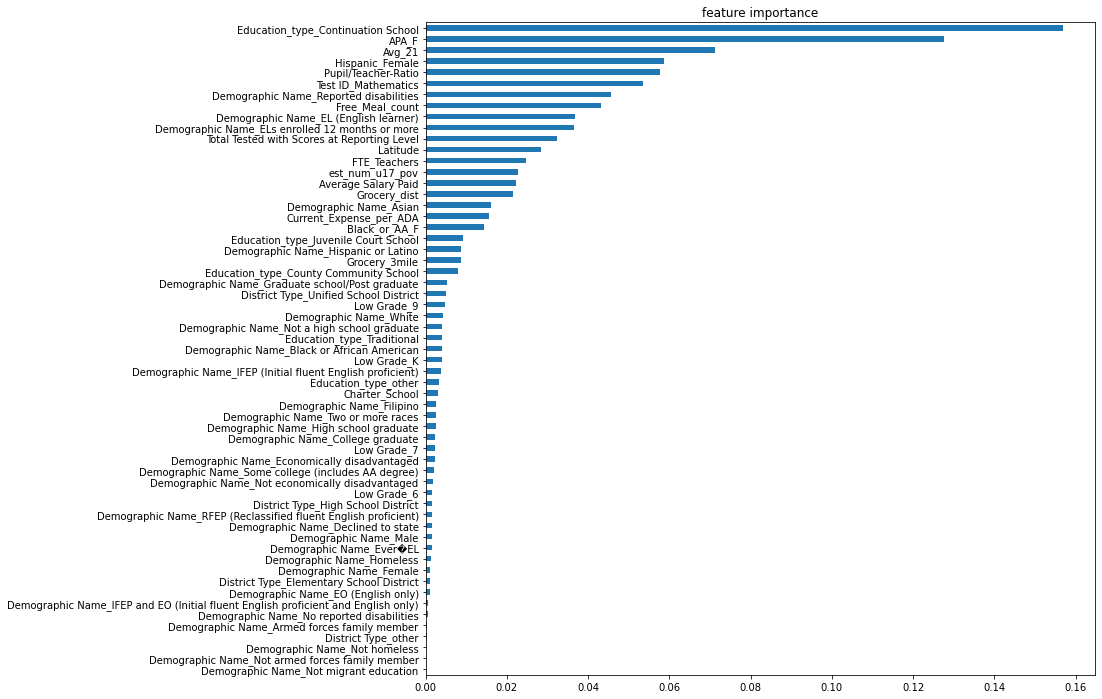

In [9]:
names = zip(model.X_columns,model.named_steps.randomforestregressor.feature_importances_)
names
fig, ax = plt.subplots(figsize=(12,12))
imps = model.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=model.X_columns).sort_values()
plt.title('feature importance')
fig = rf_feat_imps.plot(kind='barh')
plt.show()

#  Function to predict score change 

In [6]:
## for specific row/ demographic group and school site in question 

def predict_change( model,df,school,demographic,features, deltas):
    """Isolate row of df and predict change in scores due to feature change"""
    school=df[df['School_Name'].str.startswith(school)]
    group = 'Demographic Name_'+demographic
    row = school[school[group]==1]
    row = row.drop(['Mean Scale Score', 'County_Name','District_Name', 'School_Name'],axis=1)
    row = row.iloc[0].copy()
    adj_school = row.copy()
    adj_school = pd.DataFrame(adj_school) 
    for f,d in zip(features, deltas):
        adj_school.loc[f] += d
    return (model.predict(adj_school.values.reshape(1, -1)).item() - model.predict(row.values.reshape(1,-1)).item())


In [7]:
## for whole data set 
def predict_all( model,df,row,features, deltas):
    """Isolate row of df and predict change in scores due to feature change"""
    row=df.loc[row].copy()
    row = row.drop(['Mean Scale Score', 'County_Name','District_Name', 'School_Name'])
    adj_school = row.copy()
    adj_school = pd.DataFrame(adj_school)   
    for f,d in zip(features, deltas):
        adj_school.loc[f] += d
    return (model.predict(adj_school.values.reshape(1, -1)).item() - model.predict(row.values.reshape(1,-1)).item())


In [8]:
## for county level modeling 

def predict_county( model,df,row,features, deltas):
    """Isolate row of df and predict change in scores due to feature change"""
    row=df.iloc[row].copy()
    row = row.drop(['Mean Scale Score', 'County_Name','District_Name', 'School_Name'])
    adj_school = row.copy()
    adj_school = pd.DataFrame(adj_school) 
    for f,d in zip(features, deltas):
        adj_school.loc[f] += d
    return (model.predict(adj_school.values.reshape(1, -1)).item() - model.predict(row.values.reshape(1,-1)).item())


# Predict score changes due to change in salary for state.

In [9]:
# salaries adjustments to be modeled
sal_change= [i for i in range(-20000,24000,4000)]

In [125]:

salary_modeled_changes = []
start = time.time()
for row in range(len(X)):
    if row % 10000==0:
        print(row,'# preds :',len(salary_modeled_changes),'time now :',np.round((time.time()-start)/60,2))
    # only run ever 3 rows 
    if row % 30 ==0:
        # use predictive func to generate adjusted scores and store in list 
        adj_scores = [predict_all(model,
                                 df,
                                 row,['Average Salary Paid'],[delta]) for delta in sal_change]
        salary_modeled_changes.append(adj_scores)
    
print(f'it took {np.round((time.time()-start)/60,2)} seconds to run the modeling loop on {len(salary_modeled_changes)} rows')


In [54]:
len(salaray_modeled_changes)/len(X)

0.03334282730466154

## 3 % of total data set modeled in averages 

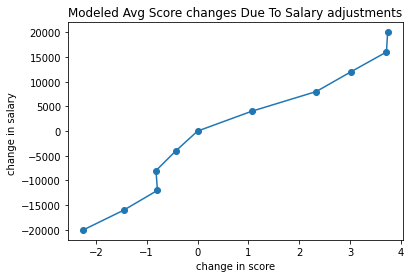

In [124]:

averages = []
start = time.time()
for idx, sal in enumerate(sal_change): 
    # list comp of nested list 
    idx = np.mean([preds[idx] for preds in salary_modeled_changes])
    averages.append(idx)

plt.plot(averages,sal_change, 'o-')
plt.title('Modeled Avg Score changes Due To Salary adjustments')
plt.xlabel('change in score')
plt.ylabel('change in salary ')
# plt.gca().invert_xaxis()
plt.show()


In [126]:
## check slope of modeled relationship 
linregress(averages,sal_change)

LinregressResult(slope=6059.557715881176, intercept=-4480.037260697443, rvalue=0.980568193628775, pvalue=1.1313484863740338e-07, stderr=404.10419317015936, intercept_stderr=879.4647107606028)

## Insight-
- from a sample of 1756 rows or 3% of the total scores a steady increase in scores can be seen from the increase of average salary paid to teachers in the state. 
- the rate of change of 1 point for each 6000$ increase in average salary. 
- the rage of increases predicted by the model are below the mean absolute error of 13 points which does not allow for there to be high confidence in the models predicted scores. 

## County wide predictions comaprisons between the counties the farthest from each other on the PCA

In [20]:
Inyo = df[df['County_Name']=='Inyo'].copy()
Santa_clara = df[df['County_Name']=='Santa Clara'].copy()

## Inyo County Modeled Score change due to increase in Average Salary 

it took 28.607886791229248 seconds to run the modeling loop on all rows
length of sample predictions :168
minutes : 0.48


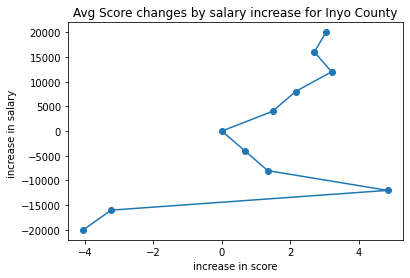

In [91]:
salary_modeled_changes = []
start = time.time()
for row in range(len(Inyo)):
    # use predictive func to generate adjusted scores and store in list 
    adj_scores = [predict_county(model,
                             Inyo,
                             row,['Average Salary Paid'],[delta]) for delta in sal_change]
    salary_modeled_changes.append(adj_scores)
    
print(f'it took {time.time()-start} seconds to run the modeling loop on all rows')
print(f'length of sample predictions :{len(salary_modeled_changes)}')
print('minutes :',np.round((time.time()-start)/60,2))

averages = []
start = time.time()
for idx, sal in enumerate(sal_change):
 
    # list comp of nested list 
    idx = np.mean([preds[idx] for preds in salary_modeled_changes])
    averages.append(idx)

# graph averages 
plt.plot(averages,sal_change, 'o-')
plt.title('Avg Score changes by salary increase for Inyo County')
plt.xlabel('increase in score')
plt.ylabel('increase in salary ')
# plt.gca().invert_xaxis()
plt.show()

## Insight
- after 12,000 increase in salary the model does not show an increase in score. 
- the rage of increases predicted by the model are below the mean absolute error of 13 points which does 

## Santa Clara County Modeled Score change due to increase in Average Salary 

0
334
667
it took 168.17 minutes to run the modeling loop on all rows
length of sample predictions :846


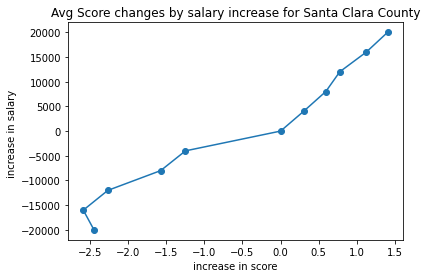

In [93]:
# with negatives 
salary_modeled_changes = []
start = time.time()
for row in range(len(Santa_clara)):
    # use predictive func to generate adjusted scores and store in list
    if row %1000 ==0:
        print(len(salary_modeled_changes))
    if row % 3 ==0:
        adj_scores = [predict_county(model,
                                 Santa_clara,
                                 row,['Average Salary Paid'],[delta]) for delta in sal_change]
        salary_modeled_changes.append(adj_scores)
    
print(f'it took {np.round(time.time()-start,2)} minutes to run the modeling loop on {(len(salary_modeled_changes))} rows')


# get averages for each salary increase 
averages = []
for idx, sal in enumerate(sal_change):
    # list comp of nested list 
    idx = np.mean([preds[idx] for preds in salary_modeled_changes])
    averages.append(idx)

# graph averages 
plt.plot(averages,sal_change, 'o-')
plt.title('Avg Score changes by salary increase for Santa Clara County')
plt.xlabel('increase in score')
plt.ylabel('increase in salary ')
# plt.gca().invert_xaxis()
plt.show()


## Insight 
- a clear linear relatiohsip between scores and salary is being modeled
- the increase in scores are below to mean absolute error not allowing for confidence in the direct predictions made for this county 

# Modelinge effects of change in teacher funding for different parent education groups

In [12]:
no_high = df[df['Demographic Name_Not a high school graduate']==1]
no_high.shape

(1148, 63)

In [13]:
post = df[df['Demographic Name_Graduate school/Post graduate']==1]
post.shape

(902, 63)

## No high School graduation student score modeling 

it took 215.68126702308655 seconds to run the modeling loop on all rows
length of sample predictions :1148
minutes : 3.59


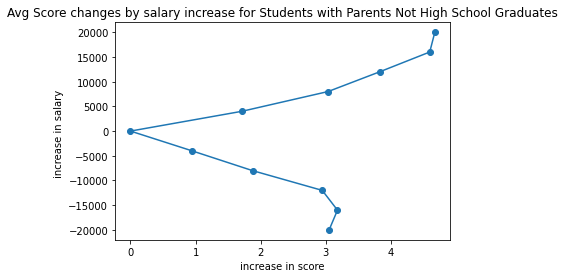

In [14]:
salary_modeled_changes = []
start = time.time()
for row in range(len(no_high)):
    # use predictive func to generate adjusted scores and store in list 
    adj_scores = [predict_county(model,
                             no_high,
                             row,['Average Salary Paid'],[delta]) for delta in sal_change]
    salary_modeled_changes.append(adj_scores)
    
print(f'it took {time.time()-start} seconds to run the modeling loop on all rows')
print(f'length of sample predictions :{len(salary_modeled_changes)}')
print('minutes :',np.round((time.time()-start)/60,2))

averages = []
start = time.time()
for idx, sal in enumerate(sal_change):
 
    # list comp of nested list 
    idx = np.mean([preds[idx] for preds in salary_modeled_changes])
    averages.append(idx)

# graph averages 
plt.plot(averages,sal_change, 'o-')
plt.title('Avg Score changes by salary increase for Students with Parents Not High School Graduates')
plt.xlabel('increase in score')
plt.ylabel('increase in salary ')
# plt.gca().invert_xaxis()
plt.show()

## Insight
- Increases in salary showed a increase in test score. 
- Model showing increase in score with decrease in salary. 
- the inverted effect of salary change does not point to a linear relationship between this groups modeled test scores. 

## Modeling Post/ Graduate educated parent scores

it took 205.77470421791077 seconds to run the modeling loop on all rows
length of sample predictions :902
minutes : 3.43


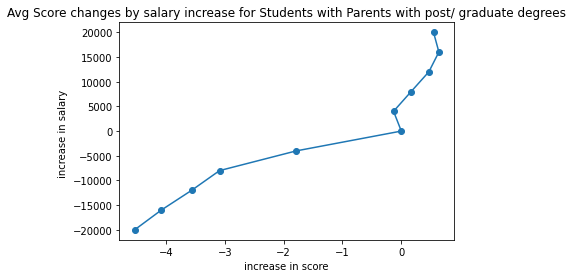

In [22]:
salary_modeled_changes = []
start = time.time()
for row in range(len(post)):
    # use predictive func to generate adjusted scores and store in list 
    adj_scores = [predict_county(model,
                             post,
                             row,['Average Salary Paid'],[delta]) for delta in sal_change]
    salary_modeled_changes.append(adj_scores)
    
print(f'it took {time.time()-start} seconds to run the modeling loop on all rows')
print(f'length of sample predictions :{len(salary_modeled_changes)}')
print('minutes :',np.round((time.time()-start)/60,2))

averages = []
start = time.time()
for idx, sal in enumerate(sal_change):
 
    # list comp of nested list 
    idx = np.mean([preds[idx] for preds in salary_modeled_changes])
    averages.append(idx)

# graph averages 
plt.plot(averages,sal_change, 'o-')
plt.title('Avg Score changes by salary increase for Students with Parents with post/ graduate degrees')
plt.xlabel('increase in score')
plt.ylabel('increase in salary ')
# plt.gca().invert_xaxis()
plt.show()

## Insight
- a decrease in salary was modeled to decrease scores but and increase in scores showed less than a point difference in scores. 
- This could show students with parents with the highest educations are in the school districts with the highest paid teachers and the model does not predicit an increase in salary having any more decernable effect. 

it took 270.5074441432953 seconds to run the modeling loop on all rows
length of sample predictions :1480
minutes : 4.51


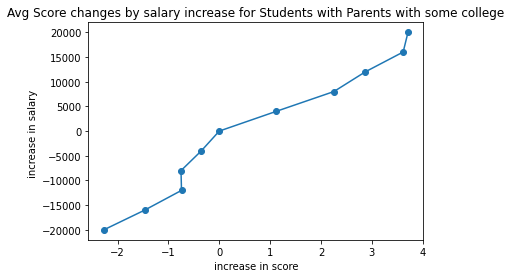

In [23]:
some_C = df[df['Demographic Name_Some college (includes AA degree)']==1]
salary_modeled_changes = []
start = time.time()
for row in range(len(some_C)):
    # use predictive func to generate adjusted scores and store in list 
    adj_scores = [predict_county(model,
                             some_C,
                             row,['Average Salary Paid'],[delta]) for delta in sal_change]
    salary_modeled_changes.append(adj_scores)
    
print(f'it took {time.time()-start} seconds to run the modeling loop on all rows')
print(f'length of sample predictions :{len(salary_modeled_changes)}')
print('minutes :',np.round((time.time()-start)/60,2))

averages = []
start = time.time()
for idx, sal in enumerate(sal_change):
 
    # list comp of nested list 
    idx = np.mean([preds[idx] for preds in salary_modeled_changes])
    averages.append(idx)

# graph averages 
plt.plot(averages,sal_change, 'o-')
plt.title('Avg Score changes by salary increase for Students with Parents with some college')
plt.xlabel('increase in score')
plt.ylabel('increase in salary ')
# plt.gca().invert_xaxis()
plt.show()

# Modeling effect of change in housing price on scores

In [ ]:
housing_delta = [i for i in range(-500000,600000,100000)]

## Sample whole data frame for average score change due to change in housing price

In [109]:

housing_modeled_changes = []
start = time.time()
for row in range(len(X)):
    if row % 10000==0:
        print(row,'# preds :',len(housing_modeled_changes),'time now :',time.time()-start)
    # only run ever 3 rows 
    if row % 30 ==0:
        # use predictive func to generate adjusted scores and store in list 
        adj_scores = [predict_all(model,
                                 df,
                                 row,['Avg_21'],[delta]) for delta in housing_delta]
        housing_modeled_changes.append(adj_scores)
    
print(f'it took {np.round((time.time()-start)/60,2)} minutes seconds to run the modeling loop on {len(housing_modeled_changes)} rows')



averages = []
start = time.time()
for idx, sal in enumerate(housing_delta): 
    # list comp of nested list 
    idx = np.mean([preds[idx] for preds in housing_modeled_changes])
    averages.append(idx)

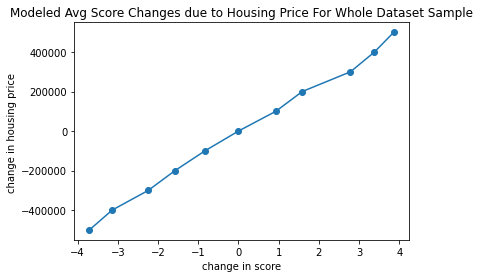

In [107]:
# graph averages 
plt.plot(averages,housing_delta, 'o-')
plt.title('Modeled Avg Score Changes due to Housing Price For Whole Dataset Sample')
plt.xlabel('change in score')
plt.ylabel('change in housing price ')
# plt.gca().invert_xaxis()
plt.show()

## Insight 
- Clear linear relationship between housing price and change in score modeled. 
- ratio of change modeled is 1 point per 100,000 increase in housing price. 

# Modeling effect of Full Time Teachers on scores 

In [18]:
teachers = [i for i in range(-20,24,4)]
teachers

[-20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20]

## Whole Data Set Sample 

In [110]:

teaching_modeled_changes = []
start = time.time()
for row in range(len(X)):
    if row % 10000==0:
        print(row,'# preds :',len(teaching_modeled_changes),'time now :',np.round((time.time()-start)/60,2))
    # only run ever 3 rows 
    if row % 30 ==0:
        # use predictive func to generate adjusted scores and store in list 
        adj_scores = [predict_all(model,
                                 df,
                                 row,['FTE_Teachers'],[delta]) for delta in teachers]
        teaching_modeled_changes.append(adj_scores)
    
print(f'it took {np.round((time.time()-start)/60,2)} minutes seconds to run the modeling loop on {len(teaching_modeled_changes)} rows')

averages = []
start = time.time()
for idx, sal in enumerate(teachers): 
    # list comp of nested list 
    idx = np.mean([preds[idx] for preds in teaching_modeled_changes])
    averages.append(idx)

0 # preds : 0 time now : 0.0
10000 # preds : 334 time now : 0.99
20000 # preds : 667 time now : 2.7
30000 # preds : 1000 time now : 3.86
40000 # preds : 1334 time now : 5.31
50000 # preds : 1667 time now : 7.18
it took 7.84 minutes seconds to run the modeling loop on 1756 rows


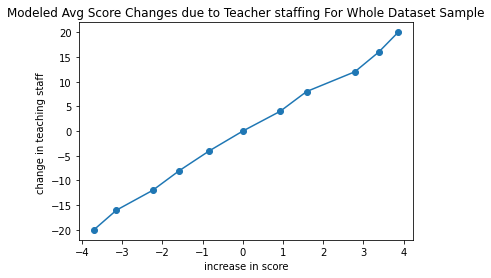

In [111]:
# graph averages 
plt.plot(averages,teachers, 'o-')
plt.title('Modeled Avg Score Changes due to Teacher staffing For Whole Dataset Sample')
plt.xlabel('increase in score')
plt.ylabel('change in teaching staff ')
# plt.gca().invert_xaxis()
plt.show()

In [120]:
# Check slope of modeled relationship 
linregress(averages,teachers)


LinregressResult(slope=1.0099390525143719, intercept=-2.2257428039733824, rvalue=0.9028143801090861, pvalue=0.0001412759429853879, stderr=0.1603521030751, intercept_stderr=1.847284877248075)

## Insight
- clear linear relationship between scores and change in teaching staff modeled. 
- the rate of modeled change is one point increase for each teacher added. 

# LA County 

In [94]:
la = df[df['County_Name']=='Los Angeles'].copy()
len(la)

12341

In [114]:

teaching_modeled_changes = []
start = time.time()
for row in range(len(la)):
    if row % 1000==0:
        print(row,'# preds :',len(teaching_modeled_changes),'time now :',np.round((time.time()-start)/60,2))
    # only run ever 3 rows 
    if row % 3 ==0:
        # use predictive func to generate adjusted scores and store in list 
        adj_scores = [predict_county(model,
                                 la,
                                 row,['FTE_Teachers'],[delta]) for delta in teachers]
        teaching_modeled_changes.append(adj_scores)
    
print(f'it took {np.round((time.time()-start)/60,2)} minutes seconds to run the modeling loop on {len(teaching_modeled_changes)} rows')


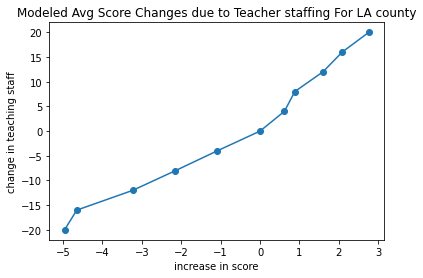

In [115]:
averages = []
start = time.time()
for idx, sal in enumerate(teachers): 
    # list comp of nested list 
    idx = np.mean([preds[idx] for preds in teaching_modeled_changes])
    averages.append(idx)

# graph averages 
plt.plot(averages,teachers, 'o-')
plt.title('Modeled Avg Score Changes due to Teacher staffing For LA county')
plt.xlabel('increase in score')
plt.ylabel('change in teaching staff')
# plt.gca().invert_xaxis()
plt.show()

## Santa Clara County Teaching Modeling

it took 2.5761666666666665 minutes to run the modeling loop on 846 rows


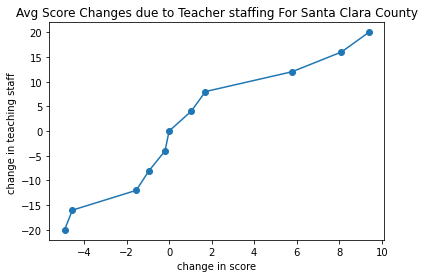

In [21]:
 
teaching_modeled_changes = []
start = time.time()
for row in range(len(Santa_clara)):
    # use predictive func to generate adjusted scores and store in list 
    if row % 3 ==0:
        adj_scores = [predict_county(model,
                                 Santa_clara,
                                 row,['FTE_Teachers'],[delta]) for delta in teachers]
        teaching_modeled_changes.append(adj_scores)
    
print(f'it took {np.round(time.time()-start,2)/60} minutes to run the modeling loop on {len(teaching_modeled_changes)} rows')

# get averages for each salary increase 
averages = []
for idx, sal in enumerate(teachers):
    # list comp of nested list 
    idx = np.mean([preds[idx] for preds in teaching_modeled_changes])
    averages.append(idx)

# graph averages 
plt.plot(averages,teachers, 'o-') 
plt.title('Avg Score Changes due to Teacher staffing For Santa Clara County')
plt.xlabel('change in score')
plt.ylabel('change in teaching staff ')
# plt.gca().invert_xaxis()
plt.show()


## Observing change for specific groups in Jefferson unified High School District 

- as an ex high school teacher at oceana I wanted to see what the model would output for schools in the district.
- I compared score changes to salary increases at 3 school sites
- The two larger schools predictions seemed reasonable as it showed an increase in score with wage but the smaller school showed an inverse of that. Model bias / ability to model might be effected by 

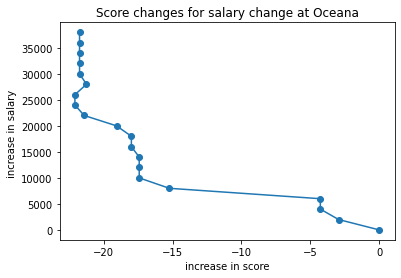

In [11]:


score_deltas = [predict_change(model,df,
                            'Oceana','Filipino',
                            ['Average Salary Paid'],[delta]) for delta in sal_change]
score_deltas
plt.plot(score_deltas,sal_change, 'o-')
plt.title('Score changes for salary change at Oceana')
plt.xlabel('increase in score')
plt.ylabel('increase in salary ')
# plt.gca().invert_xaxis()
plt.show()

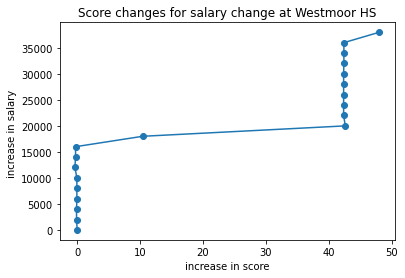

In [9]:


score_deltas = [predict_change(model,df,
                            'Westmoor','Filipino',
                            ['Average Salary Paid'],[delta]) for delta in sal_change]
score_deltas
plt.plot(score_deltas,sal_change, 'o-')
plt.title('Score changes for salary change at Westmoor HS')
plt.xlabel('increase in score')
plt.ylabel('increase in salary ')
# plt.gca().invert_xaxis()
plt.show()

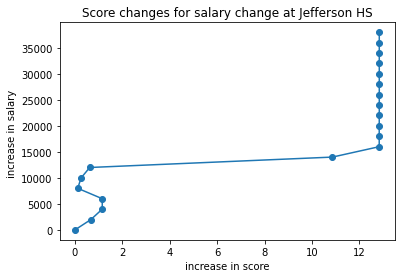

In [10]:


score_deltas = [predict_change(model,df,
                            'Jefferson High','Filipino',
                            ['Average Salary Paid'],[delta]) for delta in sal_change]
score_deltas
plt.plot(score_deltas,sal_change, 'o-')
plt.title('Score changes for salary change at Jefferson HS')
plt.xlabel('increase in score')
plt.ylabel('increase in salary ')
# plt.gca().invert_xaxis()
plt.show()

# Change in full time teachers on scores modeling 

In [380]:
teachers = [i for i in range(-20,24,4)]
teachers

[0, 4, 8, 12, 16, 20]

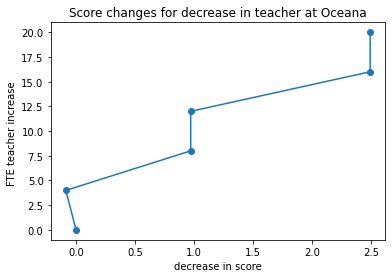

In [381]:

score_deltas = [predict_change(model,df,
                            'Oceana','Filipino',
                            ['FTE_Teachers'],[delta]) for delta in teachers]
score_deltas
plt.plot(score_deltas,teachers, 'o-')
plt.title('Score changes for decrease in teacher at Oceana')
plt.xlabel('decrease in score')
plt.ylabel('FTE teacher increase ')
# plt.gca().invert_xaxis()
plt.show()

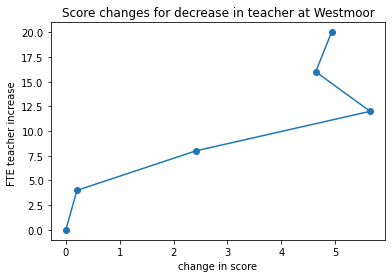

In [383]:

score_deltas = [predict_change(model,df,
                            'Westmoor','Filipino',
                            ['FTE_Teachers'],[delta]) for delta in teachers]
score_deltas
plt.plot(score_deltas,teachers, 'o-')
plt.title('Score changes for decrease in teacher at Westmoor')
plt.xlabel('change in score')
plt.ylabel('FTE teacher increase ')
# plt.gca().invert_xaxis()
plt.show()

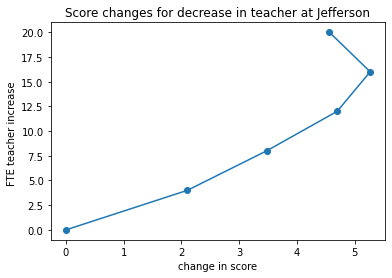

In [385]:

score_deltas = [predict_change(model,df,
                            'Jefferson','Filipino',
                            ['FTE_Teachers'],[delta]) for delta in teachers]
score_deltas
plt.plot(score_deltas,teachers, 'o-')
plt.title('Score changes for decrease in teacher at Jefferson')
plt.xlabel('change in score')
plt.ylabel('FTE teacher increase ')
# plt.gca().invert_xaxis()
plt.show()